# Predicting daily bike rental ridership

In this project, we'll build our first neural network and use it to predict daily bike rental ridership.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading and preparing the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data.

In [2]:
# Change accordingly
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()  # Peak first 5 rows

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1, 2011 to December 31, 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. We can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days in the data set. We can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. We'll try to capture all this with our model.

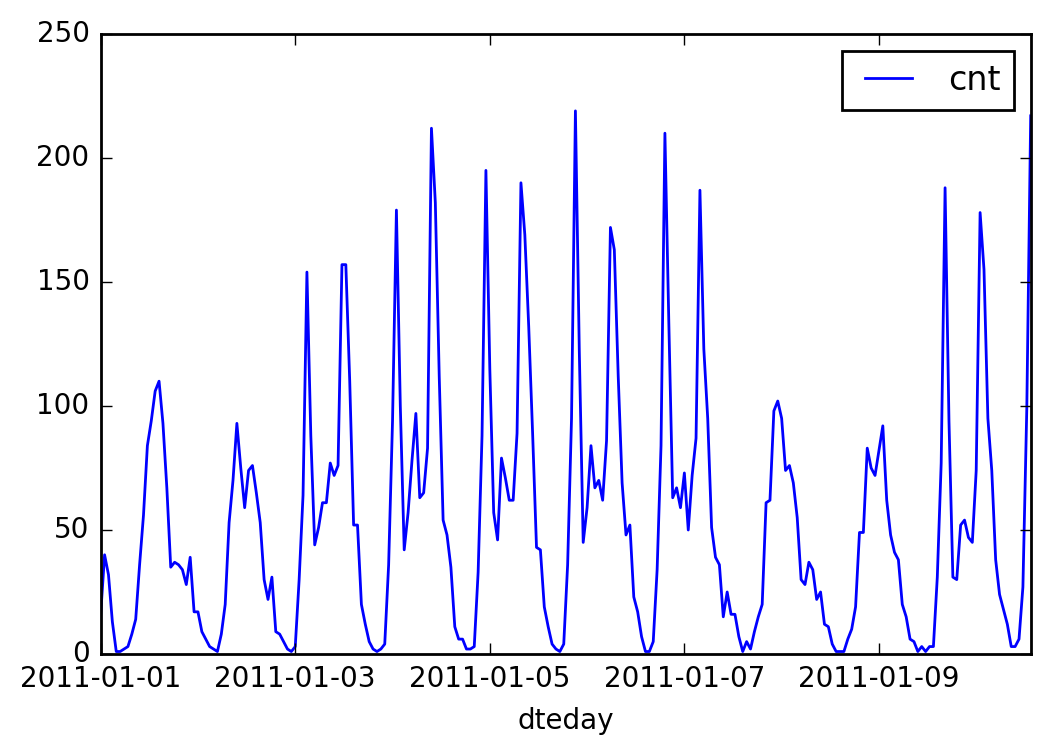

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']

data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean) / std

### Splitting the data into training, testing, and validation sets

We'll save the last 21 days of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save the last 21 days 
test_data = data[-21 * 24:]
data = data[:-21 * 24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

Given that the output activation function is $f(x) = x$, we know beforehand that its derivative will be equals to 1.
  

In [9]:
def sigmoid(x): 
    return 1 / (1 + np.exp(-x))

class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes ** -0.5, 
                                       size=(self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes ** -0.5, 
                                       size=(self.output_nodes, self.hidden_nodes))
        
        self.lr = learning_rate
        
        # Activation function is the sigmoid function
        self.activation_function = sigmoid
    
    def train(self, inputs_list, targets_list):
        
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        n_inputs = inputs.shape[0]
        
        ############# Forward pass #############
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        
        ############# Backward pass ############# 
        # Output error (the gradient is just 1)
        output_errors = targets - final_outputs
        output_grad = 1
        
        # Hidden error & gradient
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)
        hidden_grad = hidden_outputs * (1 - hidden_outputs)
        
        # Update weights
        self.weights_hidden_to_output += self.lr * np.dot(output_errors * output_grad, hidden_outputs.T)
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors * hidden_grad, inputs.T)
 
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        return final_outputs

In [10]:
def MSE(y, Y):
    """
    Calculates mean squared error between the target values and the neural network's predictions.
    """
    return np.mean((y - Y) ** 2)

## Training the network

Here we'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, without overfitting to the data. If we train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

### Choosing the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. 

We'll pass *500* times over the data. This number might go up or down depending of the other hyperparameters (specially the learning rate).

### Choosing the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. 

Although a good choice to start at is 0.1, after many trials and error, we selected 0.05 as our final value because it provides the right balance between speed of convergence and numeric stability. If we would like to smooth our descent we could set the learning rate to 0.01 or 0.001, but then we would need to increase the number of epochs as well because the effective learning made each epoch would be way smaller. As happens many times in machine learning (and deep learning in particular), it's a tradeoff between time and accuracy.

### Choosing the number of hidden nodes
The more hidden nodes we have, the more accurate predictions the model will make. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take.

As happened with the learning rate, after several trial and error iterations, we settled at 10 hidden units in the hidden layer because it provides the right balance at hand. Nevertheless, if we would like to improve our results, we could try adding more hidden layers.

In [11]:
import sys

### Hyperparameters ###
epochs = 500
learning_rate = 0.05
hidden_nodes = 10
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5] + "\n")
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 0.0% ... Training loss: 0.781 ... Validation loss: 1.197
Progress: 0.2% ... Training loss: 0.666 ... Validation loss: 1.055
Progress: 0.4% ... Training loss: 0.618 ... Validation loss: 0.989
Progress: 0.6% ... Training loss: 0.585 ... Validation loss: 0.954
Progress: 0.8% ... Training loss: 0.561 ... Validation loss: 0.927
Progress: 1.0% ... Training loss: 0.526 ... Validation loss: 0.788
Progress: 1.2% ... Training loss: 0.507 ... Validation loss: 0.827
Progress: 1.4% ... Training loss: 0.561 ... Validation loss: 0.748
Progress: 1.6% ... Training loss: 0.441 ... Validation loss: 0.720
Progress: 1.8% ... Training loss: 0.430 ... Validation loss: 0.716
Progress: 2.0% ... Training loss: 0.405 ... Validation loss: 0.615
Progress: 2.2% ... Training loss: 0.371 ... Validation loss: 0.588
Progress: 2.4% ... Training loss: 0.366 ... Validation loss: 0.588
Progress: 2.6% ... Training loss: 0.330 ... Validation loss: 0.512
Progress: 2.8% ... Training loss: 0.337 ... Validation loss: 0

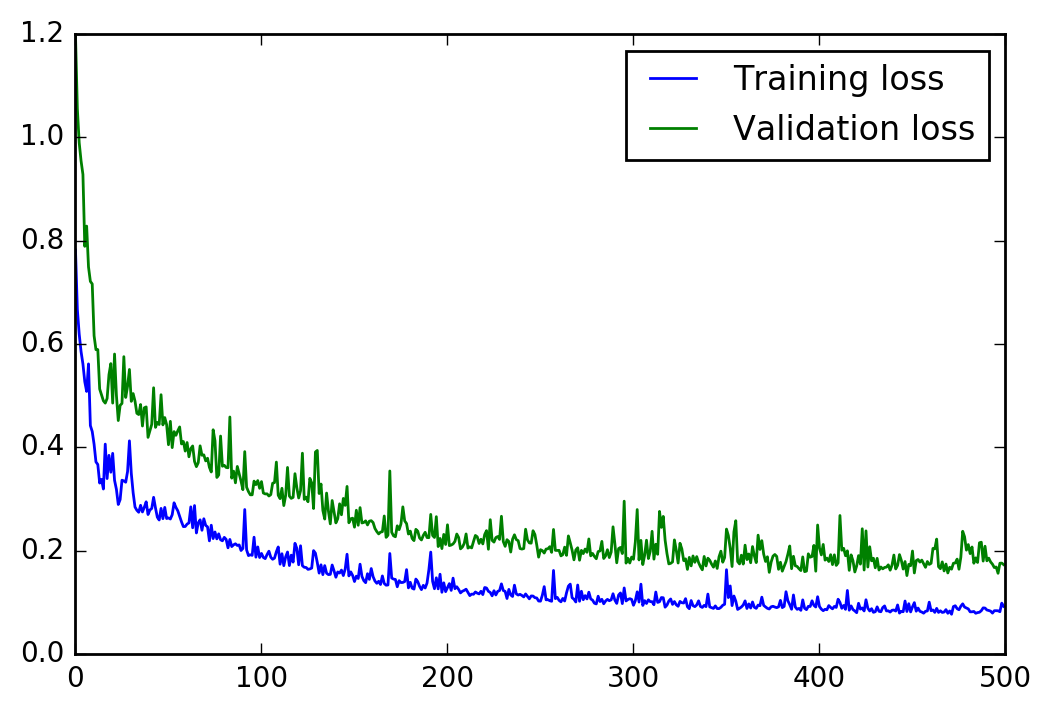

In [12]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
# plt.ylim(ymax=0.5)

## Checking out the predictions

Here we use the test data to view how well our network is modeling the data. 

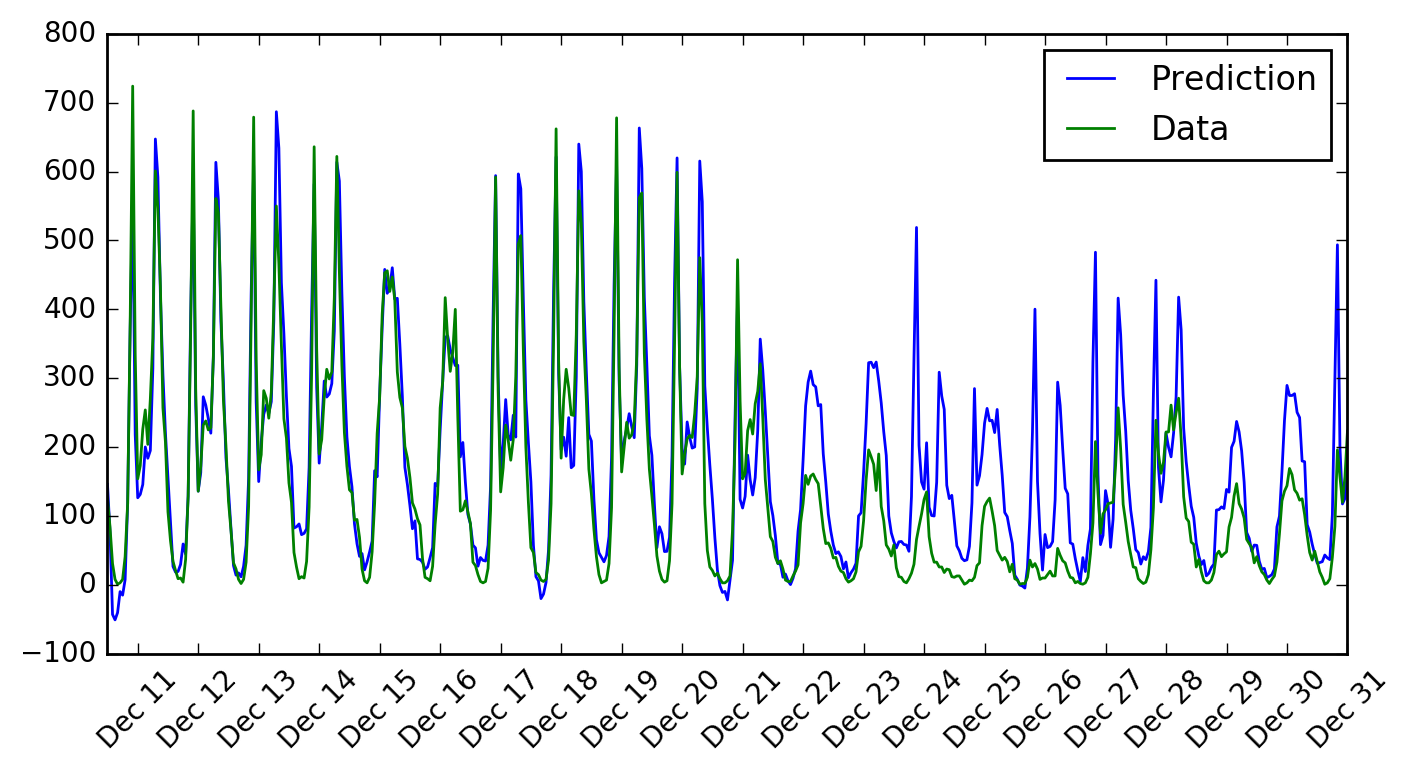

In [13]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Thinking about the results
 
How well does the model predict the data? Where does it fail? Why does it fail where it does?

> As we can see in the graphic above, our network fits very well the period ranging from December 11th to December 21st, but its predictions get worse from December 22 to December 26th. Why? Well, if we take a closer look to the graph, we see that the data in the first period has a lot of variance, peaking and dropping drastically, while in the second period these sudden jumps decrease. However, it seems clear that our network performs better in the former case than in the latter, because most of the data can be described by this spiky pattern. Hence, our network is biased towards these kind of predictions.

What can we do to improve our performance?

> There a handful of techniques or approaches we could take in order to improve our results:
* Deepen our network. This means adding more hidden layers so it can fit more complex data.
* Change the optimizer. One of the problems of SGD is that it doesn't take into account the historical data of the data, which increases its chances of getting stuck in a local minima. There are other optimizers, such as Adam, that provide a higher and safer convergence by keeping track of the gradient's momentum.
* Widen the network. By increasing the width of each layer the network could potentially fit more complex data (although most of the time deepening it, rather than widening it, provides better results).
* Use [regularization](http://neuralnetworksanddeeplearning.com/chap3.html). There are several techniques we can use in order to prevent our model from overfitting the data, a very common and unpleasant issue that arises when our model is too complex or when we train during more epochs than needed. Among the techiques we could use are L2 regularization and [Dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

## Unit tests

The purpose of these unit tests is checkin the correctness of our network implementation.

In [14]:
import unittest

inputs = [0.5, -0.2, 0.1]
targets = [0.4]
test_w_i_h = np.array([[0.1, 0.4, -0.3], 
                       [-0.2, 0.5, 0.2]])
test_w_h_o = np.array([[0.3, -0.1]])

class TestMethods(unittest.TestCase):
    
    ###############################
    # Unit tests for data loading #
    ###############################
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ########################################
    # Unit tests for network functionality #
    ########################################

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1 / (1 + np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        print('network.weights_hidden_to_output', network.weights_hidden_to_output)
        print('network.weights_input_to_hidden', network.weights_input_to_hidden)
        
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328, -0.03172939]])))
        
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014,  0.39775194, -0.29887597],
                                              [-0.20185996,  0.50074398,  0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

network.weights_hidden_to_output [[ 0.37275328 -0.03172939]]
network.weights_input_to_hidden [[ 0.10562014  0.39775194 -0.29887597]
 [-0.20185996  0.50074398  0.19962801]]



----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>